<a href="https://colab.research.google.com/github/MoMahmoud8/practise-nlp/blob/main/Text_Classification_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets 
import opendatasets as od
od.download('https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mostafamahmoudhassan
Your Kaggle Key: ··········


100%|██████████| 1.81M/1.81M [00:01<00:00, 1.81MB/s]

In [114]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import os , re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SimpleRNN, GlobalMaxPooling1D, SpatialDropout1D,GRU
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
df=pd.read_csv('/content/bbcnewsarchive/bbc-news-data.csv',sep='\t')
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [94]:
content=df['content']
category=df['category']
content[0],category[0]

(' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing customers for high

In [17]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|()|()|(\d+)")
REPLACE_WITH_SPACE = re.compile("()|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(content):
    
    content = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in content]
    content = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in content]
    
    return content


def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words


def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]


In [95]:
# content_clean = preprocess_reviews(content)
content_clean = remove_stop_words(content)
# content_clean = get_stemmed_text(content)

In [56]:
content_clean[0]

'Quarterly profits US media giant TimeWarner jumped 76% $1.13bn (£600m) three months December, $639m year-earlier. The firm, one biggest investors Google, benefited sales high-speed internet connections higher advert sales. TimeWarner said fourth quarter sales rose 2% $11.1bn $10.9bn. Its profits buoyed one-off gains offset profit dip Warner Bros, less users AOL. Time Warner said Friday owns 8% search-engine Google. But internet business, AOL, mixed fortunes. It lost 464,000 subscribers fourth quarter profits lower preceding three quarters. However, company said AOL\'s underlying profit exceptional items rose 8% back stronger internet advertising revenues. It hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL\'s existing customers high-speed broadband. TimeWarner also restate 2000 2003 results following probe US Securities Exchange Commission (SEC), close concluding. Time Warner\'s fourth quarter profits slightly better analysts\' expecta

In [57]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
oov_tok = '<OOV>' #  Out of Vocabulary
training_portion = 0.8

In [96]:
train_size = int(len(content_clean) * training_portion)

train_articles = content_clean[0: train_size]
train_labels = category[0: train_size]

validation_articles = content_clean[train_size:]
validation_labels = category[train_size:]

In [97]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445


In [98]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [99]:
word_index

{'<OOV>': 1,
 'the': 2,
 'said': 3,
 'i': 4,
 'mr': 5,
 'would': 6,
 'year': 7,
 'also': 8,
 'it': 9,
 'us': 10,
 'new': 11,
 'but': 12,
 'he': 13,
 'one': 14,
 'last': 15,
 'people': 16,
 'first': 17,
 'could': 18,
 'two': 19,
 'government': 20,
 'time': 21,
 'a': 22,
 'best': 23,
 'in': 24,
 'we': 25,
 'years': 26,
 'told': 27,
 'film': 28,
 'world': 29,
 'back': 30,
 'uk': 31,
 'made': 32,
 'three': 33,
 'labour': 34,
 '1': 35,
 'election': 36,
 '000': 37,
 'added': 38,
 'make': 39,
 'next': 40,
 'and': 41,
 'well': 42,
 'may': 43,
 'get': 44,
 'bbc': 45,
 'take': 46,
 'party': 47,
 'england': 48,
 'number': 49,
 'like': 50,
 'minister': 51,
 'good': 52,
 'since': 53,
 'win': 54,
 'british': 55,
 'public': 56,
 'blair': 57,
 'set': 58,
 'think': 59,
 'home': 60,
 'game': 61,
 'still': 62,
 'second': 63,
 '2004': 64,
 '2': 65,
 'market': 66,
 'say': 67,
 'many': 68,
 'this': 69,
 'going': 70,
 'company': 71,
 'week': 72,
 'says': 73,
 'there': 74,
 'however': 75,
 'way': 76,
 'go': 7

In [100]:
max_value = max(word_index, key=lambda k: word_index[k])
max_value , word_index[max_value]


('sharapova', 27750)

In [63]:
tokenizer.texts_to_sequences(['business cola news'])


[[151, 1, 135]]

In [101]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
len(train_sequences)

1780

In [102]:
train_sequences[0]

[3594,
 458,
 10,
 600,
 765,
 1,
 2414,
 4224,
 35,
 1,
 1,
 33,
 129,
 213,
 1,
 7,
 232,
 2,
 125,
 14,
 196,
 601,
 1,
 1,
 90,
 156,
 2339,
 1439,
 1,
 416,
 1,
 90,
 1,
 3,
 465,
 263,
 90,
 429,
 65,
 335,
 1331,
 94,
 2671,
 1133,
 458,
 1,
 14,
 656,
 2340,
 3595,
 901,
 3731,
 4982,
 1,
 308,
 1,
 1,
 21,
 4982,
 3,
 412,
 2173,
 300,
 2341,
 4431,
 1,
 12,
 1439,
 151,
 1,
 2929,
 3451,
 9,
 194,
 1,
 37,
 4692,
 465,
 263,
 458,
 733,
 1,
 33,
 2540,
 75,
 71,
 3,
 1,
 4432,
 901,
 1,
 3168,
 429,
 300,
 30,
 1585,
 1439,
 2342,
 1440,
 9,
 786,
 242,
 4692,
 2124,
 2125,
 453,
 479,
 1,
 1439,
 1249,
 320,
 1383,
 1,
 1384,
 1249,
 156,
 2339,
 4693,
 1,
 8,
 1,
 657,
 141,
 826,
 253,
 4694,
 10,
 1350,
 582,
 494,
 2126,
 426,
 1,
 21,
 1,
 465,
 263,
 458,
 1751,
 218,
 1,
 1268,
 12,
 28,
 1644,
 423,
 458,
 4433,
 888,
 1,
 787,
 678,
 168,
 1,
 2672,
 1,
 1986,
 2836,
 7,
 232,
 149,
 150,
 28,
 182,
 3169,
 1,
 2343,
 826,
 344,
 285,
 7,
 1,
 3452,
 901,
 97,
 1,
 

In [104]:
train_padded = pad_sequences(train_sequences, maxlen=max_length)
len(train_padded),len(train_padded[0])

(1780, 200)

In [105]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [106]:
set(category)

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [107]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(category)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [108]:
train_labels[0], training_label_seq[0]

('business', array([2]))

In [109]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim ))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = embedding_dim))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 dropout_4 (Dropout)         (None, None, 64)          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 328,646
Trainable params: 328,646
Non-trainable params: 0
_________________________________________________________________


In [110]:
opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [111]:
num_epochs = 20
history = model.fit(train_padded, training_label_seq, epochs=num_epochs,
                    validation_data=(validation_padded, validation_label_seq),
                    verbose=2)

Epoch 1/20
56/56 - 19s - loss: 1.5289 - accuracy: 0.2455 - val_loss: 4.6256 - val_accuracy: 0.0067 - 19s/epoch - 336ms/step
Epoch 2/20
56/56 - 14s - loss: 1.3181 - accuracy: 0.4348 - val_loss: 3.8327 - val_accuracy: 0.0404 - 14s/epoch - 248ms/step
Epoch 3/20
56/56 - 14s - loss: 0.9180 - accuracy: 0.7551 - val_loss: 4.4580 - val_accuracy: 0.0449 - 14s/epoch - 242ms/step
Epoch 4/20
56/56 - 12s - loss: 0.3105 - accuracy: 0.9725 - val_loss: 3.6092 - val_accuracy: 0.0225 - 12s/epoch - 218ms/step
Epoch 5/20
56/56 - 12s - loss: 0.0874 - accuracy: 0.9983 - val_loss: 3.9231 - val_accuracy: 0.0607 - 12s/epoch - 223ms/step
Epoch 6/20
56/56 - 13s - loss: 0.0350 - accuracy: 1.0000 - val_loss: 4.0628 - val_accuracy: 0.0652 - 13s/epoch - 225ms/step
Epoch 7/20
56/56 - 12s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 4.2312 - val_accuracy: 0.0607 - 12s/epoch - 210ms/step
Epoch 8/20
56/56 - 11s - loss: 0.0117 - accuracy: 1.0000 - val_loss: 4.3725 - val_accuracy: 0.0584 - 11s/epoch - 200ms/step
Epoch 9/

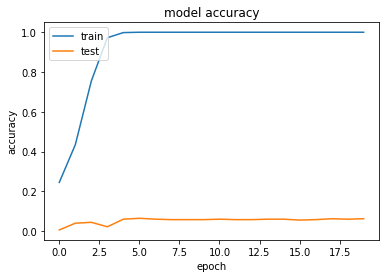

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


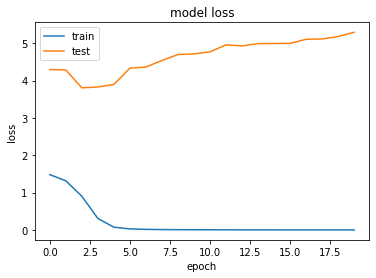

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 0s 173ms/step
[[0.00378484 0.13158026 0.3945303  0.44746736 0.00952708 0.01311025]]
3
politics


In [77]:
txt = ["call to save manufacturing jobs the trades union congress (tuc) is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies.  the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year. it calls for better pensions  child care provision and decent wages. the 36-page submission also urges the government to examine support other european countries provide to industry. tuc general secretary brendan barber called for  a commitment to policies that will make a real difference to the lives of working people.    greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents   he said.  a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontline services that this country needs.  he also called for  practical measures  to help pensioners  especially women who he said  are most likely to retire in poverty . the submission also calls for decent wages and training for people working in the manufacturing sector."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])


1/1 [==============================] - 0s 30ms/step
[[1.0173810e-03 3.0945839e-02 9.1978353e-01 8.2854717e-04 1.1654134e-03
  4.6259169e-02]]
2
bussiness
